# Neural Shape Model Tutorial #2

## Generative Signed Distance Functions

Building on Tutorial #1, we now explore **generative shape modeling** - training a 
single neural network that can represent multiple bone shapes and generate new variations!

### 🚀 What's New in This Tutorial?

**Tutorial #1** taught us to fit one neural network to **one** bone shape. 
**Tutorial #2** trains one network to represent **multiple** bone shapes using 
**latent codes**.

### 🧬 Generative Shape Modeling Concepts

**The Core Idea**: Instead of learning one specific shape, we learn a **shape space** - 
a continuous representation where:
- Each point in the space represents a different bone shape
- We can interpolate between shapes smoothly  
- We can generate entirely new bone variations
- All shapes share common anatomical structure

### 🔑 Key Technical Innovations

**1. Latent Embeddings**
```
Traditional: f(x,z) → SDF
Generative:  f(x,z,latent_code) → SDF
```
- Each bone gets a unique **latent vector** (learnable shape code)
- Network learns to decode coordinates + latent → signed distance
- Latent space captures shape variation patterns

**2. Multi-Shape Training**
- Load multiple tibia bones from different patients
- Register them to common coordinate system
- Train single network on all shapes simultaneously
- Network learns shared shape patterns + individual variations

**3. Shape Space Exploration**
- Interpolate between latent codes → morph between bone shapes
- Generate new shapes by sampling latent space
- Control specific shape characteristics

### 🎯 Learning Objectives

By the end of this tutorial, you'll understand:
1. **Latent embedding architectures** for generative modeling
2. **Multi-shape registration** and normalization pipelines
3. **Shared representation learning** across shape families
4. **Shape interpolation and generation** techniques

### 🔬 Applications

- Statistical shape models for pathology detection
- Patient-specific shape generation for surgical planning
- Population-level shape analysis studies


Let's start building our generative bone shape model!


In [13]:

# =============================================================================
# ENVIRONMENT SETUP: Install required packages for generative shape modeling
# =============================================================================

import sys
import os

if 'google.colab' in sys.modules:
    print("🔧 Setting up Google Colab environment for generative SDF tutorial...")
    
    # Update core package management tools
    %pip install --upgrade pip setuptools wheel
    
    # Download requirements specific to Colab environment
    if not os.path.exists('requirements_colab.txt'):
        !wget https://raw.githubusercontent.com/gattia/ISB-2025-Shape-Modeling/main/requirements_colab.txt
    
    # Install all required packages for:
    # - Mesh processing (pymskt, pyvista)
    # - Neural networks (pytorch)
    # - 3D visualization (itkwidgets)
    # - Scientific computing (numpy, matplotlib)
    %pip install -r requirements_colab.txt
    
    print("✅ Environment setup complete!")
else:
    print("🏠 Running in local environment - assuming packages are already installed")


🏠 Running in local environment - assuming packages are already installed


In [14]:

# =============================================================================
# LIBRARY IMPORTS: Core tools for generative shape modeling
# =============================================================================

# Medical imaging and mesh processing
import pymskt as mskt          # Advanced mesh operations and bone analysis tools
import pyvista as pv           # 3D data processing and visualization
from itkwidgets import view    # Interactive 3D visualization in Jupyter

# Core Python libraries
import glob                    # File path pattern matching for mesh loading
import os                      # Operating system interface for file operations
import json                    # JSON parsing for mesh file lists
import sys                     # System-specific parameters and functions
import math                    # Mathematical functions (for embedding initialization)

# Scientific computing
import numpy as np             # Numerical computing and array operations
import matplotlib.pyplot as plt # Plotting and visualization

# PyTorch deep learning framework
import torch                   # Main PyTorch library for tensors and autograd
import torch.nn as nn          # Neural network modules and loss functions
from torch.utils.data import Dataset, DataLoader  # Data handling utilities for batch processing

# Enable widget support for 3D visualization in Colab
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    print("📱 Enabled 3D widget support for Google Colab")

In [ ]:
# =============================================================================
# DEVICE CONFIGURATION: Set up GPU/CPU device for PyTorch
# =============================================================================

# Automatically detect the best available device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Or manually specify:
# DEVICE = torch.device('cpu')        # Force CPU
# DEVICE = torch.device('cuda')       # Force CUDA/GPU
# DEVICE = torch.device('mps')        # Force Apple Silicon GPU

print(f"Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

## Step 1: Multi-Shape Data Loading

### 🔄 From Single Shape to Shape Collection

**Tutorial #1**: Loaded one tibia bone and learned its specific geometry  
**Tutorial #2**: Load multiple tibia bones from different patients to learn shape variation patterns

### 📊 Dataset Structure

Our dataset contains tibia bones from multiple patients:
- **Left and right tibias** may exist for the same individual
    - Left are already flipped to be rights
- **Natural shape variation** representing population diversity

### 🎯 Why Multiple Shapes?

**Shape Space Learning**: 
- Single shape → Overfits to one specific geometry
- Multiple shapes → Learns shared anatomical patterns + individual variations
- Network discovers what makes a "tibia" vs. patient-specific differences

**Generative Capabilities**:
- Can interpolate between existing patient shapes
- Can generate new bone variations within learned distribution
- Enables statistical shape analysis and population studies


Let's load our bone collection and prepare for multi-shape modeling!


In [15]:
# =============================================================================
# MESH COLLECTION LOADING: Prepare multiple bone shapes for generative training
# =============================================================================

# Detect environment: Colab (remote) vs local development
is_colab = 'google.colab' in sys.modules

# =============================================================================
# MANIFEST FILE LOADING: Get list of all available mesh files
# =============================================================================

json_path = 'list_meshes.json'

# Download mesh manifest if running in Colab
if is_colab and not os.path.exists(json_path):
    print("📋 Downloading mesh file manifest...")
    !wget https://raw.githubusercontent.com/gattia/ISB-2025-Shape-Modeling/main/list_meshes.json -O list_meshes.json

# Load the complete list of available mesh filenames
# This JSON contains all tibia bone files in the dataset
with open(json_path, 'r') as f:
    mesh_list = json.load(f)  # List of VTK filenames


# =============================================================================
# PATH PREPARATION: Build file paths for each environment
# =============================================================================

list_tib_paths = []

for mesh_filename in mesh_list:
    if is_colab:
        # Remote: Construct URL for GitHub raw content access
        base_url = "https://raw.githubusercontent.com/gattia/ISB-2025-Shape-Modeling/main/data"
        path_tib_bone = f"{base_url}/{mesh_filename}"
        
    else:
        # Local: Build path to local data directory
        path_tib_bone = os.path.join('data', mesh_filename)
        
        # Skip if file doesn't exist locally (partial dataset)
        if not os.path.exists(path_tib_bone):
            print(f"⚠️ Skipping missing file: {mesh_filename}")
            continue
            
    list_tib_paths.append(path_tib_bone)



# Display first few filenames as examples
print(f"\n📋 Example bone files:")
for i, filename in enumerate(mesh_list[:3]):
    print(f"   {i+1}. {filename}")
if len(mesh_list) > 3:
    print(f"   ... and {len(mesh_list)-3} more bones")



📋 Example bone files:
   1. 9997381_RIGHT_tibia.vtk
   2. 9226874_LEFT_tibia.vtk
   3. 9368395_RIGHT_tibia.vtk
   ... and 11 more bones


## Step 2: Shape Normalization and Registration

### 🎯 The Challenge: Aligning Multiple Bones

When working with multiple bone shapes from different patients, we face several alignment challenges:

- **Different positions**: Bones scanned at different locations in space
- **Different orientations**: Varying bone rotations in the scanner
- **Different sizes**: Natural variation in bone scale between patients
- **Different coordinate systems**: Scanner-specific coordinate frameworks

### 🔧 Our Normalization Strategy
 
# **1. Centering** 📍  
 Move each bone's center of mass to the origin.
 
 **2. Scaling** 📏  
 Scale each bone to fit within a unit sphere.
 
 **3. Registration** 🎯  
 Rigidly align each bone to a reference shape.
    - We use a similarity registration (Rigid + Scaling - 7 DOF)

### 🧠 Why This Matters for Generative Learning

**Consistent Coordinate Space**:
- Network learns shape variation, not position/rotation differences
- All bones occupy same spatial region → better training efficiency
- Latent codes capture anatomical differences, not pose differences

**Numerical Stability**:
- Coordinates in [-1, 1] range → stable neural network training
- Consistent scales → gradient flow optimization  


### ⚖️ The Buffer Parameter

Notice our normalization uses a `buffer=0.2` parameter:
- Ensures bones don't touch the boundary of [-1,1] cube
- Provides spatial margin for SDF computation
- Prevents edge effects during surface reconstruction

Let's implement our normalization pipeline!


In [16]:
# =============================================================================
# SHAPE NORMALIZATION FUNCTION: Standardize bone geometry for multi-shape learning
# =============================================================================

def normalize_bone(bone, buffer=0.2):
    """
    Normalize a bone mesh to a standardized coordinate system.
    
    This function performs spatial normalization essential for training 
    generative models on multiple bone shapes from different patients.
    
    Parameters
    ----------
    bone : mskt.mesh.Mesh or pyvista.PolyData
        Input bone mesh to normalize (modified in-place)
    buffer : float, default=0.2
        Safety margin to keep bone away from unit cube boundaries
        - 0.0 = bone touches [-1,1] cube faces  
        - 0.2 = bone fits within [-0.8,0.8] cube
        
    Returns
    -------
    None
        Modifies the input bone mesh in-place
        
    Notes
    -----
    Normalization steps:
    1. Center: Translate center of mass to origin
    2. Scale: Fit bone within unit sphere with buffer
    
    This ensures all bones occupy consistent spatial regions
    while preserving relative shape proportions.
    """
    
    # STEP 1: CENTER THE BONE AT ORIGIN
    # Calculate center of mass (centroid) of all bone vertices
    mean = np.mean(bone.points, axis=0)  # Shape: (3,) for [x, y, z]
    
    # Translate bone so its center is at (0, 0, 0)
    bone.points -= mean
    
    # STEP 2: SCALE TO UNIT SPHERE WITH BUFFER
    # Compute distance from origin for each vertex
    norm = np.linalg.norm(bone.points, axis=1)  # Shape: (N,) distances
    
    # Find the furthest vertex from origin
    max_norm = np.max(norm)
    
    # Scale so max distance is (1-buffer), keeping bone inside unit cube
    # Example: buffer=0.2 → max distance becomes 0.8
    bone.points /= (max_norm / (1-buffer))
    
    # Result: Bone fits within [-0.8, 0.8]³ cube when buffer=0.2
    

## Step 3: Multi-Shape Loading and Registration

### 🎯 Building Our Bone Collection

Now we'll load multiple tibia bones and align them. This is where generative modeling begins to differ significantly from single-shape fitting.

### 🔄 Registration Pipeline

**Key Steps**:
1. **Load first bone** → Use as reference template  
2. **For each subsequent bone**:
   - Load and normalize independently
   - Rigidly register to reference bone
   - Add to collection

### 🎯 Why Registration Matters

**Without Registration**:
```
Bone A: Pointing up    ↑
Bone B: Pointing right →  
Bone C: Pointing down  ↓
```
Network learns orientation differences, not shape differences!

**With Registration**:
```
Bone A: Pointing up    ↑
Bone B: Pointing up    ↑  (rotated to match A)
Bone C: Pointing up    ↑  (rotated to match A)
```
Network learns shape variation!

### 📊 Dataset Size Considerations

For this tutorial, we'll use **5 bones** to demonstrate concepts:
- Small enough for quick training and experimentation
- Easily scalable to larger collections

Let's build our multi-shape dataset!


In [17]:
# =============================================================================
# MULTI-SHAPE LOADING AND REGISTRATION: Build aligned bone collection
# =============================================================================

# Number of bones to load for generative modeling
n = 10
print(f"🦴 Loading and registering {n} tibia bones for generative training...")

# Initialize collection to store all registered bones
list_tibs = []

# =============================================================================
# ITERATIVE LOADING: Process each bone with registration to reference
# =============================================================================

for idx in range(n):
    print(f'🔄 Processing bone {idx+1}/{n}')
    
    # Handle different loading strategies for Colab vs local environments
    if is_colab:
        # COLAB: Download bone file from GitHub and load locally
        base_url = "https://raw.githubusercontent.com/gattia/ISB-2025-Shape-Modeling/main/data"
        mesh_filename = mesh_list[idx]
        path_tib_bone_url = f"{base_url}/{mesh_filename}"
        local_path = f"/content/{mesh_filename}"  # Temporary local storage
                
        # Download bone file to Colab's temporary storage
        !wget {path_tib_bone_url} -O {local_path} -q
        
        # Load mesh using PyVista (simpler for downloaded files)
        tibia_mesh = pv.read(local_path)
        
    else:
        # LOCAL: Load directly from local data directory
        path_tib_bone = os.path.join('data', mesh_list[idx])
        
        # Skip if file doesn't exist in local dataset
        if not os.path.exists(path_tib_bone):
            print(f"⚠️ File not found locally: {path_tib_bone}")
            continue
            
        # Load using pymskt for advanced mesh operations
        tibia_mesh = mskt.mesh.Mesh(path_tib_bone)

    # =============================================================================
    # REFERENCE BONE SETUP: First bone becomes template for registration
    # =============================================================================
    
    if idx == 0:
        
        # Convert to pymskt.Mesh for advanced operations
        ref_tibia = mskt.mesh.Mesh(tibia_mesh)
        
        # Normalize to standard coordinate system
        normalize_bone(ref_tibia)
        
        # Add to collection (no registration needed for reference)
        list_tibs.append(ref_tibia)
        continue

    # =============================================================================
    # SUBSEQUENT BONES: Normalize and register to reference template
    # =============================================================================
        
    # Convert to pymskt.Mesh for registration capabilities
    tibia = mskt.mesh.Mesh(tibia_mesh)
    
    # Apply same normalization as reference bone
    normalize_bone(tibia)
    
    # Perform rigid registration to align with reference bone
    # This finds the best rotation + translation to match reference shape
    tibia.rigidly_register(ref_tibia, return_transformed_mesh=True)
    
    # Add registered bone to collection
    list_tibs.append(tibia)


🦴 Loading and registering 10 tibia bones for generative training...
🔄 Processing bone 1/10
🔄 Processing bone 2/10
🔄 Processing bone 3/10
🔄 Processing bone 4/10
🔄 Processing bone 5/10
🔄 Processing bone 6/10
🔄 Processing bone 7/10
🔄 Processing bone 8/10
🔄 Processing bone 9/10
🔄 Processing bone 10/10


## Step 4: Multi-Shape SDF Data Generation

### 🔄 From Single-Shape to Multi-Shape Training Data

**Tutorial #1**: Generated noisy points around one bone slice  
**Tutorial #2**: Generate noisy points around multiple bone slices

### 🎯 Generative Training Data Strategy

For each bone in our collection, we need to:
1. **Create 2D slice** through the registered bone
2. **Sample training points** around the slice boundary  
3. **Compute ground truth SDFs** for each point

### 🧠 Why Multi-Shape Data Generation?

**Shared Spatial Learning**:
- All bones occupy same coordinate region after registration
- Network learns individual bone differences captured via latent codes

**Balanced Training**:
- Equal sampling from each bone prevents bias toward any shape
- Network sees diverse shape variations in each batch
- Better generalization to unseen bone variations

**Regularized Latent**:
- The latent embeddings are penalized with an L2 norm
    - This promotes a continuous/compact latent space
    - Results in roughly diagonal covariance matrix

### 📊 Training Data Structure

```python
For each bone_i in collection:
    slice_i = bone_i.slice('y', origin=(0,0,0))
    points_i, sdf_i = generate_sdf_points(slice_i)
    
Training batch = {
    'coordinates': [points_1, points_2, ..., points_n],
    'sdf_values': [sdf_1, sdf_2, ..., sdf_n], 
    'bone_ids': [0, 1, ..., n-1],  # Which bone each sample came from
    'latent_codes': [z_0, z_1, ..., z_{n-1}]  # Learnable shape embeddings
}
```

### 🎛️ Data Generation Parameters

Our function maintains the same sampling strategy as Tutorial #1:
- **Close noise** (σ=0.01): High-precision surface boundary learning
- **Far noise** (σ=0.075): Inside/outside classification and distance gradients
- **Point count**: 20K points per bone for sufficient sampling density

### 💫 The Key Innovation: Shape-Aware Sampling

Unlike Tutorial #1 where we had global points and SDF values, now we have:
- **Shape-specific points**: Each point knows which bone it came from
- **Learnable latent codes**: Network learns unique embedding for each bone
- **Shared coordinate space**: All points use same spatial coordinate system

This enables the network to learn: `f(x, z, latent_bone_id) → SDF`

Let's implement our multi-shape data generation!


In [18]:

# =============================================================================
# SDF POINT GENERATION FUNCTION: Create training data for generative modeling
# =============================================================================

def generate_sdf_points_on_slice(
    mesh, 
    N=20_000, 
    close_sd=0.01, 
    far_sd=0.075, 
    slice_axis='y', 
    verbose=True,
    n_uniform=500
):
    """
    Generate noisy training points around a bone slice with ground truth SDF values.
    
    This function creates the training data needed for generative SDF learning
    by sampling points around bone surfaces and computing their signed distances.
    
    Parameters
    ----------
    mesh : mskt.mesh.Mesh or pyvista.PolyData
        The (already normalized and registered) bone mesh to process
    N : int, default=20_000
        Number of points per noise distribution (total = 2*N points)
    close_sd : float, default=0.01
        Standard deviation for near-surface point sampling
        - Smaller values → points closer to surface → better boundary precision
    far_sd : float, default=0.075  
        Standard deviation for far-surface point sampling
        - Larger values → points further from surface → better inside/outside learning
    slice_axis : str, default='y'
        Axis to slice along ('x', 'y', or 'z') - reduces 3D problem to 2D
    verbose : bool, default=True
        Whether to print progress messages during generation

    Returns
    -------
    slice_ : pyvista.PolyData
        The 2D slice extracted from the input mesh
    pts_ : pyvista.PolyData
        Generated training points with ground truth SDF values stored in 
        the 'implicit_distance' array

    Notes
    -----
    Training point generation strategy:
    1. Create 2D slice through bone (reduces computational complexity)
    2. Sample N points with small noise → near-surface training data
    3. Sample N points with large noise → far-surface training data  
    4. Compute exact SDF values for all points using mesh geometry
    
    This provides balanced training data for both surface precision
    and spatial understanding across the coordinate domain.
    """
    
    # =============================================================================
    # SLICE EXTRACTION: Reduce 3D bone to 2D cross-section
    # =============================================================================
    
    # Create 2D slice through the bone at y≈0 (after registration)
    # This simplifies the learning problem while maintaining anatomical structure
    slice_ = mesh.slice(slice_axis, origin=(0, 0, 0))

    # =============================================================================
    # POINT SAMPLING: Generate diverse training coordinates
    # =============================================================================
    
    # Initialize array for all training points (2 distributions × N points each)
    pts = np.zeros((N*2 + n_uniform, 3))
    
    # Generate two different noise distributions for comprehensive training
    for i, SD in enumerate([close_sd, far_sd]):
        distribution_name = "near-surface" if i == 0 else "far-surface"
        
        # STEP 1: Randomly select seed points on the slice boundary
        # These serve as starting locations for noise perturbation
        indices = (np.random.sample(N) * slice_.points.shape[0]).astype(int)
        
        # STEP 2: Generate Gaussian noise for coordinate perturbation
        # This creates points both inside (negative SDF) and outside (positive SDF)
        x_noise = np.random.normal(loc=0, scale=SD, size=N)
        z_noise = np.random.normal(loc=0, scale=SD, size=N)
        
        # STEP 3: Apply noise to create diverse point distribution
        pts[i*N:(i+1)*N, 0] = slice_.points[indices, 0] + x_noise  # X coordinate
        pts[i*N:(i+1)*N, 2] = slice_.points[indices, 2] + z_noise  # Z coordinate
        # Y coordinate stays 0 (slice level) - will be handled by network input
    
    # STEP 4: Sample uniformly distributed points
    # This ensures we have a uniform distribution of points across the slice
    # get points uniformly from -1 to 1 for x and z
    pts[-n_uniform:, 0] = np.random.uniform(-1, 1, n_uniform)
    pts[-n_uniform:, 2] = np.random.uniform(-1, 1, n_uniform)
    # Y coordinate stays 0 (slice level) - will be handled by network input

    # =============================================================================
    # SDF COMPUTATION: Calculate ground truth signed distances
    # =============================================================================
    
    # Convert points to PyVista format for SDF computation
    pts_ = pv.PolyData(pts)
    
    
    # Compute signed distance from each point to the original mesh surface
    # This gives us the target values our neural network will learn to predict
    pts_.compute_implicit_distance(mesh, inplace=True)
    
    return slice_, pts_

# =============================================================================
# DEMONSTRATION: Generate training data for reference bone
# =============================================================================
# Generate example training data using the reference bone
slice_, pts_ = generate_sdf_points_on_slice(
    ref_tibia, 
    N=20_000, 
    close_sd=0.01, 
    far_sd=0.075,
    slice_axis='y'
)

# Visualize the slice, full bone, and generated training points
view(geometries=[slice_, ref_tibia], point_sets=pts_, point_size=2)


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Step 5: Generative Neural Network Architecture

### 🚀 From Single-Shape to Multi-Shape Networks

**Tutorial #1 Architecture**:
```
f(x, z) → SDF
Input: 2D coordinates
Output: Signed distance for ONE specific bone
```

**Tutorial #2 Architecture**:
```
f(x, z, latent_code) → SDF  
Input: 2D coordinates + shape embedding
Output: Signed distance for ANY bone in our collection
```

### 🧬 Key Innovation: Latent Shape Embeddings

**The Challenge**: How can one network represent multiple different bones?

**The Solution**: **Latent Codes** - learnable vector embeddings that encode shape identity

```python
# Each bone gets a unique learnable vector
bone_0: [0.1, -0.3, 0.7, 0.2, ...]  # 32-dimensional embedding
bone_1: [0.4, 0.1, -0.2, 0.8, ...]  # Different embedding
bone_2: [-0.2, 0.6, 0.3, -0.1, ...]  # Yet another embedding

# Network learns: coordinates + bone_embedding → SDF
network(x=0.5, z=0.3, latent=bone_0_embedding) → SDF for bone 0
network(x=0.5, z=0.3, latent=bone_1_embedding) → SDF for bone 1
```

### 🎯 Architecture Components

**1. Latent Embedding Layer**
- `torch.nn.Embedding(num_bones, latent_dim)`
- Creates learnable vector for each bone in our collection
- Vectors start random, optimize during training to compactly capture shape differences

**2. Enhanced MLP Architecture**
```
Input: [x, z, latent_vector] → Concatenated features
Hidden Layer 1: 64 neurons + ReLU
Hidden Layer 2: 64 neurons + ReLU  
Output: Single SDF value
```

**3. Multi-Shape Dataset**
- Samples points from ALL bones during training
- Each sample includes coordinate + bone_id
- Network learns shared patterns + individual variations

### 🧠 How Learning Works

**During Training**:
1. **Sample batch**: Mix of points from different bones
2. **Lookup embedding**: Get latent vector for each bone_id
3. **Concatenate features**: [x, z, latent_vector] 
4. **Predict SDF**: Network outputs signed distance
5. **Update weights**: Both MLP weights AND latent embeddings improve

### 🎨 Generative Capabilities

Once trained, we can:

**1. Reconstruct Known Bones**
```python
bone_id = 2
latent = embedding_layer(bone_id)
sdf = network(coordinates, latent)  # Recreate bone 2
```

**2. Interpolate Between Bones**  
```python
latent_A = embedding_layer(bone_A)
latent_B = embedding_layer(bone_B)
latent_interp = 0.7 * latent_A + 0.3 * latent_B  # 70% A, 30% B
sdf = network(coordinates, latent_interp)  # New hybrid bone!
```

**3. Generate Novel Bones**
```python
latent_new = sample_from_latent_distribution()  # Random vector
sdf = network(coordinates, latent_new)  # Entirely new bone variation
```

### ⚙️ Training Configuration

**Key Parameters**:
- `latent_dim = 32`: Size of shape embedding vectors
- `batch_size = 2`: Number of bones per training batch  
- `n_samples = 500`: Points sampled per bone per batch
- `epochs = 40,000`: Extended training for generative learning

**Loss Function**:
```python
loss = L1_loss(predicted_sdf, true_sdf) + regularization(latent_embeddings)
```

**Why Regularization?**: Encourages smooth shape space - can interpolate between shapes. 

Let's build our generative shape model!


In [ ]:
# =============================================================================
# GENERATIVE NEURAL NETWORK ARCHITECTURE: Multi-shape SDF learning
# =============================================================================

class SimpleMLP(nn.Module):
    """
    Enhanced Multi-Layer Perceptron for generative SDF learning.
    
    Key difference from Tutorial #1: This network accepts both spatial coordinates
    AND latent shape embeddings, enabling it to represent multiple bone shapes.
    
    Architecture: [coordinates + latent] → hidden → hidden → SDF
    """
    def __init__(self, input_dim=2, latent_dim=32, hidden_dim=64, output_dim=1):
        """
        Initialize generative SDF network.
        
        Parameters
        ----------
        input_dim : int, default=2
            Spatial coordinate dimensions (x, z for 2D slice)
        latent_dim : int, default=32
            Size of latent shape embedding vectors
        hidden_dim : int, default=64  
            Number of neurons in hidden layers
        output_dim : int, default=1
            Output dimensions (1 for signed distance)
        """
        super(SimpleMLP, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        
        # Network concatenates spatial coordinates with shape embedding
        total_input_dim = input_dim + latent_dim
        
        self.net = nn.Sequential(
            # First hidden layer: Process combined spatial + shape features
            nn.Linear(total_input_dim, hidden_dim),
            nn.ReLU(),
            
            # Second hidden layer: Refine feature representations
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            
            # Output layer: Single SDF prediction
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, latent):
        """
        Forward pass: Predict SDF from coordinates and shape embedding.
        
        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, input_dim)
            Spatial coordinates (e.g., x, z positions)
        latent : torch.Tensor, shape (batch_size, latent_dim)
            Shape embedding vectors for each sample
            
        Returns
        -------
        torch.Tensor, shape (batch_size, 1)
            Predicted signed distance values
        """
        # Concatenate spatial coordinates with shape embeddings
        x_cat = torch.cat([x, latent], dim=-1)
        
        # Process through MLP to predict SDF
        return self.net(x_cat)

# =============================================================================
# MULTI-SHAPE DATASET: Training data for generative learning
# =============================================================================

class PointsSDFDataset(Dataset):
    """
    PyTorch Dataset for multi-shape generative SDF training.
    
    Key innovation: Generates training data from multiple bone shapes
    and associates each sample with its source bone identity.
    """
    def __init__(self, mesh_list, n_sample=500, N=20_000, close_sd=0.01, 
                 far_sd=0.075, max_sdf=0.1, slice_axis='y', verbose=False):
        """
        Initialize multi-shape training dataset.
        
        Parameters
        ----------
        mesh_list : list of mskt.mesh.Mesh
            Collection of registered bone meshes
        n_sample : int, default=500
            Number of points to sample per bone per training batch
        N : int, default=20_000
            Total points generated per bone (2*N due to two noise levels)
        close_sd : float, default=0.01
            Standard deviation for near-surface point sampling
        far_sd : float, default=0.075
            Standard deviation for far-surface point sampling  
        max_sdf : float, default=0.1
            Clamp SDF values to focus learning on surface proximity
        slice_axis : str, default='y'
            Axis for 2D slice extraction
        verbose : bool, default=False
            Print progress during data generation
        """
        
        self.xz = []        # Spatial coordinates for each bone
        self.sdf = []       # SDF values for each bone  
        self.n_sample = n_sample
        
        # Generate training data for each bone in the collection
        for i, mesh in enumerate(mesh_list):
            if verbose:
                print(f"   Processing bone {i+1}/{len(mesh_list)}")
                
            # Generate SDF training points using our established function
            _, pts_ = generate_sdf_points_on_slice(
                mesh, N=N, close_sd=close_sd, far_sd=far_sd, 
                slice_axis=slice_axis, verbose=verbose
            )
            
            # Extract coordinate data (x, z) - ignore y since we're using slices
            pts = pts_.points  # Shape: (2*N, 3)
            sdf = pts_['implicit_distance']  # Shape: (2*N,)
            
            # Convert to PyTorch tensors
            xz_tensor = torch.tensor(pts[:, [0, 2]], dtype=torch.float32).to(DEVICE)
            sdf_tensor = torch.tensor(sdf, dtype=torch.float32).unsqueeze(1).to(DEVICE)
            
            # Clamp SDF values to focus learning on surface region
            sdf_tensor = torch.clamp(sdf_tensor, min=-max_sdf, max=max_sdf)
            
            # Store bone-specific training data
            self.xz.append(xz_tensor)
            self.sdf.append(sdf_tensor)
        
        # Verify consistent data sizes across all bones
        self.point_batch_size = self.xz[0].shape[0]

    def __len__(self):
        """Return number of bones in dataset."""
        return len(self.xz)

    def __getitem__(self, idx):
        """
        Sample training data for the idx-th bone.
        
        Returns
        -------
        tuple
            (bone_idx, coordinates, sdf_values)
            - bone_idx: Which bone this data came from (for latent lookup)
            - coordinates: Random sample of spatial positions  
            - sdf_values: Corresponding ground truth signed distances
        """
        # Randomly sample n_sample points from this bone's full dataset
        N = self.xz[idx].shape[0]
        indices = np.random.choice(N, size=self.n_sample, replace=False)
        
        return idx, self.xz[idx][indices], self.sdf[idx][indices]

# =============================================================================
# TRAINING CONFIGURATION: Setup for generative learning
# =============================================================================

print("⚙️ Configuring generative SDF training...")

# Training hyperparameters - optimized for multi-shape learning
num_epochs = 40_000      # Extended training for generative models
n_samples = 500          # Points sampled per bone per batch
batch_size = 2           # Number of different bones per training batch
latent_dim = 8          # Dimensionality of shape embeddings
latent_init_std = 0.1    # Initial scale of latent vectors
slice_axis = 'y'         # Slice direction for 2D learning

# =============================================================================
# LATENT EMBEDDING LAYER: Learnable shape codes
# =============================================================================


# Create embedding layer: each bone gets a learnable latent vector
lat_vecs = torch.nn.Embedding(
    num_embeddings=len(list_tibs),  # One embedding per bone
    embedding_dim=latent_dim,       # 32-dimensional shape codes
    max_norm=10.0                   # Prevent embeddings from growing too large
).to(DEVICE)

# Initialize embeddings with small random values
# This ensures training starts from a reasonable state
torch.nn.init.normal_(
    lat_vecs.weight.data,
    mean=0.0,
    std=latent_init_std / math.sqrt(latent_dim),  # Scaled initialization
)


# =============================================================================
# DATASET AND MODEL INITIALIZATION
# =============================================================================

# Create multi-shape dataset
dataset = PointsSDFDataset(
    mesh_list=list_tibs, 
    n_sample=n_samples, 
    N=20_000,
    close_sd=0.01, 
    far_sd=0.075,
    max_sdf=0.1, 
    slice_axis=slice_axis,
    verbose=False  # Set to True for detailed data generation logs
)

# Create data loader for efficient batch processing
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size,  # Process multiple bones per batch
    shuffle=True            # Randomize bone order each epoch
)

# Initialize generative network
model = SimpleMLP(
    input_dim=2,           # 2D coordinates (x, z)
    latent_dim=latent_dim, # Shape embedding size
    hidden_dim=32,         # Network capacity
    output_dim=1           # Single SDF output
).to(DEVICE)

# Setup optimization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()  # L1 loss for sharp surface reconstruction

# =============================================================================
# TRAINING LOOP: Learn generative SDF representation
# =============================================================================

print(f"\n🚀 Starting generative SDF training...")


for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Process each batch (contains multiple bones)
    for batch_idx, (bone_indices, xz_coords, sdf_targets) in enumerate(dataloader):
        # move batch data to device
        bone_indices =  bone_indices.to(DEVICE)
        xz_coords = xz_coords.to(DEVICE)
        sdf_targets = sdf_targets.to(DEVICE)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # STEP 1: Lookup latent embeddings for bones in this batch
        latents = lat_vecs(bone_indices)  # Shape: (batch_size, latent_dim)
        
        # STEP 2: Expand latents to match coordinate samples 
        # We need the same latent vector for all points from the same bone
        latents = latents.unsqueeze(1).expand(-1, n_samples, -1)  # (batch, n_samples, latent_dim)
        
        # STEP 3: Predict SDF values using coordinates + shape embeddings
        pred_sdf = model(xz_coords, latents)
        
        # STEP 4: Compute loss components
        # SDF reconstruction loss - how well we predict signed distances
        sdf_loss = criterion(pred_sdf, sdf_targets)
        
        # Latent regularization - prevent embeddings from growing too large
        lat_loss = torch.sum(torch.norm(latents, dim=-1))
        
        # Combined loss: reconstruction + regularization
        total_loss = sdf_loss + lat_loss
        
        # STEP 5: Backpropagation and parameter updates
        total_loss.backward()
        optimizer.step()
        
        # Accumulate loss statistics
        running_loss += total_loss.item() * xz_coords.size(0)
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Progress reporting
    if epoch % 1000 == 0:
        print(f"Epoch {epoch+1:5d}/{num_epochs:,} | Loss: {epoch_loss:.6f}")



⚙️ Configuring generative SDF training...

🚀 Starting generative SDF training...
Epoch     1/40,000 | Loss: 99.810660
Epoch  1001/40,000 | Loss: 99.629613
Epoch  2001/40,000 | Loss: 99.625876
Epoch  3001/40,000 | Loss: 99.625165
Epoch  4001/40,000 | Loss: 99.624567
Epoch  5001/40,000 | Loss: 99.623991
Epoch  6001/40,000 | Loss: 99.623381
Epoch  7001/40,000 | Loss: 99.623387
Epoch  8001/40,000 | Loss: 99.622818
Epoch  9001/40,000 | Loss: 99.622792
Epoch 10001/40,000 | Loss: 99.622437
Epoch 11001/40,000 | Loss: 99.622279
Epoch 12001/40,000 | Loss: 99.622377
Epoch 13001/40,000 | Loss: 99.622137
Epoch 14001/40,000 | Loss: 99.622057
Epoch 15001/40,000 | Loss: 99.621951
Epoch 16001/40,000 | Loss: 99.621799
Epoch 17001/40,000 | Loss: 99.621756
Epoch 18001/40,000 | Loss: 99.621898
Epoch 19001/40,000 | Loss: 99.621808
Epoch 20001/40,000 | Loss: 99.621698
Epoch 21001/40,000 | Loss: 99.621571
Epoch 22001/40,000 | Loss: 99.621632
Epoch 23001/40,000 | Loss: 99.621707
Epoch 24001/40,000 | Loss: 99.6

## Step 6: Evaluating the Generative Model

### 🎯 From Training to Generation

Your generative SDF model is now trained. Unlike Tutorial #1 where we learned one specific bone, we now have a model that can:

1. **Reconstruct any of the 5 training bones**
2. **Interpolate between different bone shapes**  
3. **Generate entirely new bone variations**

### 🎨 Visualization Strategy

We'll evaluate our model by:

**Grid-Based SDF Evaluation**:
- Create dense 2D grid of query points
- For a specific bone, lookup its latent embedding
- Predict SDF values across the entire grid
- Visualize the learned SDF field

**Surface Reconstruction**:
- Use marching cubes to extract zero level set
- Compare reconstructed surface to original bone
- Assess geometric accuracy and smoothness

### 🔧 Model Evaluation Process

```python
# STEP 1: Choose which bone to reconstruct
LATENT_IDX = 0  # Bone index (0 to 4 in our case)

# STEP 2: Get the learned latent embedding for this bone  
latent_code = embedding_layer(LATENT_IDX)

# STEP 3: Create grid of query coordinates
grid_coordinates = create_coordinate_grid()

# STEP 4: Predict SDF values using coordinates + latent code
sdf_predictions = model(grid_coordinates, latent_code)

# STEP 5: Visualize and reconstruct
visualize_sdf_field(sdf_predictions)
reconstruct_surface(sdf_predictions)
```

### 🎛️ Key Parameters

**Grid Resolution**: Controls detail level of reconstruction
- Higher resolution → more detailed surfaces, slower computation
- Lower resolution → faster computation, less detail

**Latent Index**: Which bone to reconstruct
- `LATENT_IDX = 0` → First bone (reference)
- `LATENT_IDX = 1` → Second bone  
- etc.

### 🚀 What to Look For

**Successful Learning Indicators**:
- SDF field smoothly transitions from negative (inside) to positive (outside)
- Zero level set closely matches original bone shape
- Different latent codes produce different bone geometries
- No artifacts or discontinuities in the SDF field

**Quality Assessment**:
- **Geometric accuracy**: How well does reconstruction match original?
- **Surface smoothness**: Are there any jagged artifacts?
- **Shape diversity**: Do different bones look appropriately different?

Let's evaluate our trained generative model!


In [ ]:
# =============================================================================
# SDF FIELD VISUALIZATION: Evaluate learned generative representation
# =============================================================================

# Choose which bone to reconstruct (0 to 4 for our 5-bone dataset)
LATENT_IDX = 0

# =============================================================================
# GRID GENERATION: Create dense coordinate sampling for SDF evaluation
# =============================================================================


# Create high-resolution coordinate grid for detailed SDF field visualization
GRID_STEP = 0.01  # Grid resolution (smaller = more detailed, slower)
x = np.arange(-1, 1.01, GRID_STEP)
z = np.arange(-1, 1.01, GRID_STEP)

# Create coordinate meshgrid and flatten for network evaluation
xx, zz = np.meshgrid(x, z)
xz_grid = np.stack([xx.ravel(), zz.ravel()], axis=1)

# Convert to PyTorch tensor for model inference  
xz_tensor = torch.from_numpy(xz_grid).float().to(DEVICE)

# =============================================================================
# GENERATIVE SDF PREDICTION: Query network with specific latent code
# =============================================================================


# Disable gradient computation for inference (faster, less memory)
with torch.no_grad():
    # STEP 1: Lookup learned latent embedding for the specified bone
    latent = lat_vecs(torch.tensor(LATENT_IDX)).to(DEVICE)
    
    # STEP 2: Expand latent to match number of query points
    # Each coordinate gets the same latent code (identifies the bone shape)
    latent_expanded = latent.expand(xz_tensor.size(0), -1)
    
    # STEP 3: Predict SDF values across the entire grid
    sdf_pred = model(xz_tensor, latent_expanded).cpu().numpy().flatten()

# =============================================================================
# VISUALIZATION PREPARATION: Convert predictions to 3D point cloud
# =============================================================================

# Convert 2D grid coordinates to 3D points (x, 0, z) for visualization
# Y = 0 since we're working with a slice through the bone
xyz_coords = np.stack([
    xz_grid[:, 0],                    # X coordinates  
    np.zeros_like(xz_grid[:, 0]),     # Y = 0 (slice level)
    xz_grid[:, 1]                     # Z coordinates
], axis=1)

# Create PyVista point cloud for interactive visualization
xyz_points = pv.PolyData(xyz_coords)

# Assign predicted SDF values as point data for color mapping
xyz_points['Predicted_SDF'] = sdf_pred

# =============================================================================
# INTERACTIVE VISUALIZATION: Compare learned vs. original bone
# =============================================================================

# Get original slice for comparison
original_slice = list_tibs[LATENT_IDX].slice('y', origin=(0,0,0))

# Create interactive 3D visualization comparing:
# 1. Original bone slice (wireframe)
# 2. Original full bone (solid)
# 3. Learned SDF field (colored points)
view(
    geometries=[original_slice, list_tibs[LATENT_IDX]], 
    point_sets=xyz_points, 
    point_size=2
)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Step 7: Generative Surface Reconstruction

### 🎯 From SDF Field to 3D Surface

The previous visualization showed us the raw SDF field as colored points. Now we'll extract the actual bone surface using marching cubes. 

### 🎨 Reconstruction Process

**Our Approach**:
1. **Setup 3D grid** for marching cubes algorithm
2. **Choose target bone** via latent index
3. **Predict SDF field** using coordinates + latent embedding
4. **Extract zero level set** where SDF transitions from negative to positive
5. **Compare reconstruction** with original bone geometry

### 🧪 Experimental Possibilities

Once you understand this process, try:

**Explore Different Bones**:
```python
LATENT_IDX = 0  # First bone
LATENT_IDX = 1  # Second bone  
LATENT_IDX = 2  # Third bone
# etc.
```

**Shape Interpolation** (advanced):
```python
latent_A = lat_vecs(torch.tensor(0))  # First bone
latent_B = lat_vecs(torch.tensor(1))  # Second bone
latent_interp = 0.5 * latent_A + 0.5 * latent_B  # 50/50 blend
# Use latent_interp for reconstruction → hybrid bone!
```

**Novel Shape Generation** (advanced):
```python
latent_new = torch.randn(latent_dim) * 0.1  # Random latent code
# Use latent_new for reconstruction → entirely new bone variation!
```

### 🎯 Quality Assessment

**What to Look For**:
- **Surface smoothness**: Clean, artifact-free reconstruction
- **Anatomical accuracy**: Preserved bone structure and proportions
- **Shape diversity**: Different bones should look appropriately different
- **Boundary precision**: Sharp transitions between inside/outside regions

### 📊 Reconstruction Parameters

**Grid Resolution**: Balance between detail and computation time
- `n = 100` → Quick preview reconstruction  
- `n = 200` → High-detail reconstruction (slower)

**Spatial Bounds**: Ensure we cover the bone region
- `[-1, 1]` range matches our normalized coordinate system

Let's extract our generative bone surface!


In [ ]:
# =============================================================================
# GENERATIVE SURFACE RECONSTRUCTION: Extract bone geometry from learned SDF
# =============================================================================

# =============================================================================
# MARCHING CUBES GRID SETUP: Create structured 3D grid for surface extraction
# =============================================================================


# Grid resolution for surface extraction (balance detail vs. computation)
n = 100  # Grid points per dimension (higher = more detail, slower)

# Spatial bounds matching our normalized coordinate system
x_min, y_min, z_min = -1.0, -0.01, -1.0   # Minimum bounds
x_max, y_max, z_max =  1.0,  0.01,  1.0    # Maximum bounds

print(f"   • Grid resolution: {n} × 2 × {n} = {n*2*n:,} total points")
print(f"   • Spatial coverage: X[{x_min}, {x_max}], Y[{y_min}, {y_max}], Z[{z_min}, {z_max}]")

# Calculate grid spacing
spacing = (
    (x_max - x_min) / (n - 1),  # X direction spacing
    0.01,                       # Y direction spacing (thin slice)
    (z_max - z_min) / (n - 1),  # Z direction spacing
)

# Create structured grid for marching cubes algorithm
grid = pv.ImageData(
    dimensions=(n, 2, n),     # Grid dimensions
    spacing=spacing,          # Point spacing
    origin=(x_min, y_min, z_min),  # Grid origin
)

# Extract grid coordinates for SDF evaluation
x, y, z = grid.points.T


# =============================================================================
# GENERATIVE SDF EVALUATION: Predict signed distances across the grid
# =============================================================================


# Prepare coordinate input for the neural network
# Extract (x, z) coordinates since we're working with 2D slices
xz_grid_3d = np.stack([x, z], axis=1)
xz_tensor_3d = torch.from_numpy(xz_grid_3d).float().to(DEVICE)


# Predict SDF values using the trained generative model
with torch.no_grad():
    # Get the learned latent embedding for the target bone
    latent = lat_vecs(torch.tensor(LATENT_IDX)).to(DEVICE)
    
    # Expand latent to match all grid points (same bone identity for all points)
    latent_expanded = latent.expand(xz_tensor_3d.size(0), -1)
    
    # Generate SDF predictions across the entire grid
    sdf_pred_3d = model(xz_tensor_3d, latent_expanded).cpu().numpy().flatten()
    
# =============================================================================
# MARCHING CUBES: Extract zero level set as triangulated surface
# =============================================================================


# Extract isosurface where SDF = 0 (the bone boundary)
# This creates a triangulated mesh representing the reconstructed bone surface
reconstructed_mesh = grid.contour([0], sdf_pred_3d, method='marching_cubes')

# Compute surface normals for proper lighting and visualization
reconstructed_mesh.compute_normals(inplace=True)

# =============================================================================
# COMPARISON PREPARATION: Get original bone slice for reference
# =============================================================================


# Extract slice from the original bone for visual comparison
original_slice = list_tibs[LATENT_IDX].slice('y', origin=(0, 0, 0))

# =============================================================================
# FINAL VISUALIZATION: Compare reconstruction with original
# =============================================================================

# Create interactive visualization comparing:
# 1. Generative reconstruction (colored surface)
# 2. Original bone slice (wireframe reference)
view(geometries=[reconstructed_mesh, original_slice])


   • Grid resolution: 100 × 2 × 100 = 20,000 total points
   • Spatial coverage: X[-1.0, 1.0], Y[-0.01, 0.01], Z[-1.0, 1.0]


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Step 8: Exploring the Shape Space - Mean Shape Generation

### 🎯 Beyond Individual Reconstruction

So far, we've reconstructed specific bones using their individual latent codes. But our generative model enables something even more powerful: **shape space exploration**!

### 🧬 The Concept of "Average" Shapes

One of the most interesting properties of latent shape spaces is the ability to compute **canonical** or **average** shapes:

```python
# Individual bone shapes:
bone_0 = f(coordinates, latent_vector_0)  # Patient A's specific anatomy
bone_1 = f(coordinates, latent_vector_1)  # Patient B's specific anatomy

# Average bone shape:
mean_latent = (latent_vector_0 + latent_vector_1 + ...) / num_bones
average_bone = f(coordinates, mean_latent)  # Population average anatomy!
```

### 🔬 Why Average Shapes Matter

**Statistical Shape Analysis**:
- **Population norms**: What does a "typical" tibia look like?
- **Pathology detection**: How far is a patient's bone from the population average?
- **Reference templates**: Standardized anatomy for medical education

**Clinical Applications**:
- **Surgical planning**: Start with average anatomy, then personalize
- **Implant design**: Design for the population average, then customize
- **Growth modeling**: Track how individual bones deviate from population means

**Research Applications**:
- **Shape variation studies**: Understanding anatomical diversity
- **Developmental biology**: How shapes change with age/development
- **Comparative anatomy**: Differences between populations or species



Let's generate and visualize the population average tibia!


In [ ]:
# =============================================================================
# MEAN SHAPE GENERATION: Explore the center of our learned shape space
# =============================================================================

# =============================================================================
# LATENT SPACE ANALYSIS: Compute statistics of learned shape embeddings
# =============================================================================

# Extract all learned latent embeddings for analysis
all_latents = lat_vecs.weight.data  # Shape: (num_bones, latent_dim)

# Compute latent space statistics
latent_mean = all_latents.mean(dim=0, keepdim=True)  # Population center
latent_std = all_latents.std(dim=0)                  # Per-dimension variation
latent_range = all_latents.max(dim=0)[0] - all_latents.min(dim=0)[0]  # Value ranges

# =============================================================================
# RECONSTRUCTION GRID SETUP: Same spatial domain as individual bones
# =============================================================================

# Use same grid parameters as individual bone reconstruction for comparison
n = 100  # Grid resolution
x_min, y_min, z_min = -1.0, -0.01, -1.0   # Spatial bounds
x_max, y_max, z_max =  1.0,  0.01,  1.0

# Create reconstruction grid
spacing = (
    (x_max - x_min) / (n - 1),  # X spacing
    0.01,                       # Y spacing (thin slice)  
    (z_max - z_min) / (n - 1),  # Z spacing
)

grid = pv.ImageData(
    dimensions=(n, 2, n),
    spacing=spacing,
    origin=(x_min, y_min, z_min),
)

x, y, z = grid.points.T

# =============================================================================
# MEAN SHAPE SDF GENERATION: Use population average latent code
# =============================================================================


# Prepare spatial coordinates for network evaluation
xz_grid_3d = np.stack([x, z], axis=1)
xz_tensor_3d = torch.from_numpy(xz_grid_3d).float().to(DEVICE)

# Generate SDF predictions using the MEAN of all learned latent embeddings
with torch.no_grad():
    # CRITICAL: Use mean of all latent vectors → "average" bone shape
    # This represents the center point of our learned shape space
    latent_mean = lat_vecs.weight.mean(dim=0, keepdim=True)
    
    # Expand mean latent to match all grid points
    latent_expanded = latent_mean.expand(xz_tensor_3d.size(0), -1)
    
    # Predict SDF field for the "average" bone
    sdf_pred_3d = model(xz_tensor_3d, latent_expanded).cpu().numpy().flatten()


# =============================================================================
# SURFACE EXTRACTION: Extract average bone geometry
# =============================================================================


# Extract zero level set → average bone surface
mean_bone_mesh = grid.contour([0], sdf_pred_3d, method='marching_cubes')
mean_bone_mesh.compute_normals(inplace=True)

# =============================================================================
# COMPARISON VISUALIZATION: Mean vs. individual reference bone
# =============================================================================


# Create visualization showing:
# 1. Population average bone (generated from mean latent)
# 2. Reference individual bone slice (for comparison)
original_slice = list_tibs[0].slice('y')  # Use first bone as reference
view(geometries=[mean_bone_mesh, original_slice])


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Epoch 1/500, Loss: 0.0105
Latent norm: 0.0377
Epoch 2/500, Loss: 0.0109
Latent norm: 0.0376
Epoch 3/500, Loss: 0.0104
Latent norm: 0.0385
Epoch 4/500, Loss: 0.0093
Latent norm: 0.0432
Epoch 5/500, Loss: 0.0098
Latent norm: 0.0497
Epoch 6/500, Loss: 0.0099
Latent norm: 0.0536
Epoch 7/500, Loss: 0.0094
Latent norm: 0.0558
Epoch 8/500, Loss: 0.0094
Latent norm: 0.0568
Epoch 9/500, Loss: 0.0094
Latent norm: 0.0563
Epoch 10/500, Loss: 0.0092
Latent norm: 0.0554
Epoch 11/500, Loss: 0.0088
Latent norm: 0.0555
Epoch 12/500, Loss: 0.0086
Latent norm: 0.0571
Epoch 13/500, Loss: 0.0085
Latent norm: 0.0599
Epoch 14/500, Loss: 0.0085
Latent norm: 0.0615
Epoch 15/500, Loss: 0.0083
Latent norm: 0.0629
Epoch 16/500, Loss: 0.0082
Latent norm: 0.0655
Epoch 17/500, Loss: 0.0079
Latent norm: 0.0683
Epoch 18/500, Loss: 0.0077
Latent norm: 0.0713
Epoch 19/500, Loss: 0.0076
Latent norm: 0.0750
Epoch 20/500, Loss: 0.0075
Latent norm: 0.0784
Epoch 21/500, Loss: 0.0073
Latent norm: 0.0818
Epoch 22/500, Loss: 0.

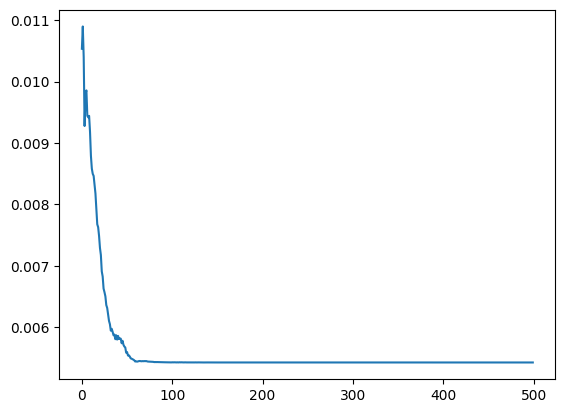

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# ===========================
# LOAD AND PREPARE TEST MESH
# ===========================

# Load in a new/test mesh (not seen during training)
test_mesh = mskt.mesh.Mesh(list_tib_paths[-3])

# Scale the test mesh so it's close to the size of the reference mesh
normalize_bone(test_mesh)

# Register the new mesh with the reference mesh (rigid registration)
test_mesh.rigidly_register(ref_tibia, return_transform=True)

# Extract a 2D slice from the registered/scaled mesh in the y direction
test_slice = test_mesh.slice('y', origin=(0, 0, 0))

# Get the slice's x and z coordinates (to match training input format)
test_slice_points = torch.from_numpy(test_slice.points[:, [0, 2]]).float().to(DEVICE)

# ==========================================
# LATENT VECTOR INITIALIZATION AND OPTIMIZER
# ==========================================

# Create a new latent vector with random values close to zero (mean=0, std=0.02)
latent = torch.ones(1, latent_dim).normal_(mean=0, std=0.01).to(DEVICE)
latent.requires_grad = True  # Enable gradient computation for optimization

# Set up optimizer to optimize ONLY the latent vector (not the network weights)
optimizer = torch.optim.Adam([latent], lr=1e-2)

# Training hyperparameters
n_epochs = 500           # Number of optimization steps
lr_decay = 0.99          # Learning rate decay per epoch
latent_norm_weight = 1e-7   # Regularization weight for latent norm (set to small value here)

# Lists to store loss and learning rate history for plotting
losses = []
lrs = []

# ==========================================
# OPTIMIZE LATENT VECTOR TO FIT TEST SLICE
# ==========================================

for iter in range(n_epochs):
    optimizer.zero_grad()
    
    # Expand latent vector to match the number of slice points
    latent_input = latent.expand(test_slice.points.shape[0], -1).float()
    
    # Input points from new slice into network, along with the new latent vector
    # Predict the SDF values for these points
    sdf_pred = model(test_slice_points, latent_input)
    
    # Compute L1 loss between predicted SDF and the ground truth SDF (which is 0 for the surface)
    recon_loss = torch.mean(torch.abs(sdf_pred))
    
    # Optionally regularize the latent vector norm (encourage it to stay small/ more "plausible")
    latent_loss = torch.norm(latent)
    
    # Total loss: reconstruction + (optionally) latent regularization
    loss = recon_loss + latent_loss * latent_norm_weight
    
    # Backpropagate and update the latent vector
    loss.backward()
    optimizer.step()
    
    # Print progress for monitoring
    print(f"Epoch {iter+1}/{n_epochs}, Loss: {loss.item():.4f}")
    print(f"Latent norm: {latent_loss.item():.4f}")
    
    # Store loss and learning rate for plotting
    losses.append(loss.item())
    lrs.append(optimizer.param_groups[0]['lr'])
    
    # Decay the learning rate
    optimizer.param_groups[0]['lr'] *= lr_decay

# Plot the loss curve over optimization
plt.figure()
plt.plot(losses)
plt.show()

# ==========================================================
# RECONSTRUCTION GRID SETUP: MATCH TRAINING SPATIAL DOMAIN
# ==========================================================

# Use same grid parameters as individual bone reconstruction for comparison
n = 100  # Grid resolution (number of points along x and z)
x_min, y_min, z_min = -1.0, -0.01, -1.0   # Spatial bounds (match training)
x_max, y_max, z_max =  1.0,  0.01,  1.0

# Create a 3D grid for SDF evaluation (thin in y, dense in x and z)
spacing = (
    (x_max - x_min) / (n - 1),  # X spacing
    0.01,                       # Y spacing (thin slice)  
    (z_max - z_min) / (n - 1),  # Z spacing
)

grid = pv.ImageData(
    dimensions=(n, 2, n),       # 2 voxels in y (thin)
    spacing=spacing,
    origin=(x_min, y_min, z_min),
)

# Extract grid coordinates for SDF prediction
x, y, z = grid.points.T

# ==========================================
# GENERATE SDF FIELD USING OPTIMIZED LATENT
# ==========================================

# Prepare spatial coordinates for network evaluation (x and z only)
xz_grid_3d = np.stack([x, z], axis=1)
xz_tensor_3d = torch.from_numpy(xz_grid_3d).float()

# Use the optimized latent vector to generate SDF predictions for the grid
with torch.no_grad():
    # Expand latent vector to match number of grid points
    latent_ = latent.expand(xz_tensor_3d.size(0), -1).float()
    # Predict SDF field for the fitted latent vector
    sdf_pred_3d = model(xz_tensor_3d, latent_).cpu().numpy().flatten()

# ==========================================
# EXTRACT SURFACE FROM SDF FIELD
# ==========================================

# Extract the zero level set (isosurface) → reconstructed bone surface
fitted_test_bone_mesh = grid.contour([0], sdf_pred_3d, method='marching_cubes')
fitted_test_bone_mesh.compute_normals(inplace=True)

# ==========================================
# VISUALIZE: ORIGINAL SLICE VS RECONSTRUCTION
# ==========================================

# Create visualization showing:
# 1. Reconstructed bone surface (from optimized latent)
# 2. Original test bone slice (for comparison)
view(geometries=[fitted_test_bone_mesh, test_slice])


## Tutorial Complete: Generative Shape Modeling Achieved!

You've successfully built and trained a **generative neural shape model** that can represent multiple bone shapes in a single network.

### Key Parts

**1. Multi-Shape Learning** 🦴
- Loaded and registered 5 different tibia bones from different patients
- Aligned them into a consistent coordinate system for shared learning

**2. Generative Architecture** 🧠
- Built latent embedding layer to encode shape identity
- Enhanced MLP to process coordinates + shape embeddings
- Learned both shared anatomical patterns AND individual variations

**3. Advanced Training** 📈
- Multi-shape dataset with bone identity tracking
- Extended training (40K epochs) for generative learning
- Regularized latent codes to encourage smooth shape space

**4. Shape Reconstruction** 🎨
- Demonstrated reconstruction of specific bones via latent codes
- Visualized learned SDF fields across spatial domains
- Extracted high-quality surfaces using marching cubes

**5. Shape Space Exploration** 🧬
- Generated population average bone using latent arithmetic
- Demonstrated canonical shape generation and latent space analysis
- Explored the center of the learned shape space

### 🎯 From Tutorial #1 to Tutorial #2

| Aspect | Tutorial #1 (Single Shape) | Tutorial #2 (Generative) |
|--------|----------------------------|---------------------------|
| **Input** | `f(x,z) → SDF` | `f(x,z,latent) → SDF` |
| **Capacity** | One specific bone | Multiple bone shapes |
| **Training Data** | 40K points from 1 bone | 100K+ points from 5 bones |
| **Applications** | Surface fitting | Shape generation & interpolation |
| **Generalization** | Fixed geometry | Variable anatomy |
| **Shape Space** | Single point | Multi-dimensional space |

### 🧪 Next Steps & Advanced Explorations

**Shape Interpolation** 🌟
```python
# Blend between two different bones
latent_A = lat_vecs(torch.tensor(0))  # Patient A
latent_B = lat_vecs(torch.tensor(1))  # Patient B
latent_hybrid = 0.7 * latent_A + 0.3 * latent_B  # 70% A, 30% B
# Use latent_hybrid to generate a morphed bone shape!
```

**Shape Space Analysis** 📊
- Compute distances between latent codes → bone similarity analysis
- Principal Component Analysis on latent vectors → major shape variation modes
- Clustering latent codes → discover bone types/populations

**Novel Shape Generation** 🎲
- Sample random latent vectors → generate entirely new bone variations
- Conditional generation based on patient metadata (age, gender, etc.)
- Shape completion: predict missing bone regions

**Scaling to Full 3D** 🌍
- Extend to full 3D coordinates (x,y,z) instead of 2D slices
- Higher resolution grids for detailed reconstructions
- Multiple anatomical structures (femur, humerus, etc.)


- **Virtual reality**: Haptic interaction with anatomical models

### 💡 Research Directions

This tutorial demonstrates the foundations of **neural implicit shape modeling** - a rapidly advancing field with connections to:

- **3D Deep Learning**: Point clouds, voxels, meshes
- **Generative AI**: VAEs, GANs, diffusion models for 3D
- **Medical AI**: Shape-based diagnosis and treatment planning
- **Computer Vision**: 3D reconstruction from images

### 🎓 Key Takeaways

1. **Latent embeddings** enable single networks to represent multiple shapes
2. **Registration and normalization** are critical for multi-shape learning
3. **Regularization** promotes smooth, interpolatable shape spaces
4. **Neural SDFs** provide continuous, resolution-independent shape representation
5. **Generative modeling** opens doors to shape synthesis and analysis
6. **Shape space arithmetic** enables semantic manipulation of 3D geometry


**Happy generating!** 🚀
